In [22]:
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pyodbc 
from sqlalchemy import create_engine
import re
import networkx as nx
import matplotlib.pyplot as plt
import string
import pymongo

In [23]:
nltk.download('stopwords')
stop_words.add('amp')

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
# Set up Mongo database connection
client = pymongo.MongoClient()
db = client['GA_Runoffs']

# Create test userdata collection
requested_accounts = db['requested_accounts']
twitter_user_data = db['twitter_user_data']
collected_tweets = db['collected_tweets']

In [25]:
# Collect all posts with hashtag #demcastga

tweets = db.collected_tweets.find({"$text": {"$search":"#demcastga"}}, {'entities.hashtags.tag':1,
                                                                              'category':1, 'username':1,
                                                                              'created_at':1, 'text':1,
                                                                            'author_id':1})

In [26]:
demcast_tweets = pd.DataFrame(list(tweets))

In [27]:
len(demcast_tweets)

2224

In [28]:
demcast_tweets.head()

,_id,author_id,created_at,entities,text,category
0,5fee3ff288da48afa84f5738,803276164714393604,2020-12-25T12:01:07.000Z,{'hashtags': [{'tag': 'DemCastGA'}]},#DemCastGA,demcast_ecosystem
1,5fee3fea88da48afa84f5653,1083771575348781056,2020-12-27T15:38:38.000Z,{'hashtags': [{'tag': 'GeorgiansVoteRevWarnock...,#GeorgiansVoteRevWarnockAndOssoffToSaveAmerica...,demcast_ecosystem
2,5fee3fe088da48afa84f54b5,1254891029179830272,2020-12-29T18:48:02.000Z,"{'hashtags': [{'tag': 'VoteOssoffWarnock'}, {'...",@KMResistInOC Change starts with our Votes! \n...,demcast_ecosystem
3,5ff36ebb93c05a63bd7a67fd,798350810648379392,2021-01-01T18:27:35.000Z,{'hashtags': [{'tag': 'DemCastGA'}]},@LEBassett #DemCastGA,demcast_ecosystem
4,5ff36eb193c05a63bd7a664b,896725875626041344,2021-01-04T03:22:29.000Z,"{'hashtags': [{'tag': 'DemCast'}, {'tag': 'Dem...",#DemCast #DemCastGA,demcast_ecosystem


In [29]:
demcast_tweets[['created_at', 'text']].head(100)

,created_at,text
0,2020-12-25T12:01:07.000Z,#DemCastGA
1,2020-12-27T15:38:38.000Z,#GeorgiansVoteRevWarnockAndOssoffToSaveAmerica...
2,2020-12-29T18:48:02.000Z,@KMResistInOC Change starts with our Votes! \n...
3,2021-01-01T18:27:35.000Z,@LEBassett #DemCastGA
4,2021-01-04T03:22:29.000Z,#DemCast #DemCastGA
...,...,...
95,2021-01-01T17:57:36.000Z,#DemCastGA 👇👇👇 https://t.co/rK1M81heZC
96,2021-01-01T18:49:42.000Z,#DemCastGA 👇👇👇👇 https://t.co/cafIamNpVf
97,2021-01-01T18:54:34.000Z,#DemCastGA 👇👇👇👇 https://t.co/2S5MJRha0q
98,2021-01-01T21:09:02.000Z,#DemcastGA #FlipTheSenateBlueGA https://t.co/7...


In [30]:
def clean_text(data):
  data = data.lower() #this may trigger a  warning...
  data = ' '.join([word for word in data.split(' ') if word not in stop_words])
  # data = ' '.join([word for word in data.split(' ') if word not in stopwords])
  data = data.encode('ascii', 'ignore').decode()
  data = re.sub(r'https*\S+', ' ', data)
  data = re.sub(r'@\S+', ' ', data)
  data = re.sub(r'#\S+', ' ', data)
  data = re.sub(r'\'\w+', '', data)
  data = re.sub('[%s]' % re.escape(string.punctuation), ' ', data)
  data = re.sub(r'\w*\d+\w*', '', data)
  data = re.sub(r'\s{2,}', ' ', data)
  data = ' '.join([word for word in data.split(' ') if word not in stop_words])
  # data = ' '.join([word for word in data.split(' ') if word not in stopwords])
  return data

In [31]:
demcast_tweets['cleantext'] = demcast_tweets['text'].apply(clean_text) 
demcast_tweets = demcast_tweets[demcast_tweets['cleantext'].notnull()]
demcast_tweets['cleantext'].reset_index(drop=True).head(20)

0                                                     
1                                                     
2      change starts votes end obstruction washington 
3                                                     
4                                                     
5                                                     
6                                                     
7                                                     
8                                                     
9                                                     
10                                                    
11                                                    
12                                                    
13                                                    
14                                                    
15                                                    
16                                                    
17                                                    
18        

In [32]:
demcast_tweets['cleantext'].reset_index(drop=True).head(100)

0                                                     
1                                                     
2      change starts votes end obstruction washington 
3                                                     
4                                                     
                            ...                       
95                                                    
96                                                    
97                                                    
98                                                    
99                                                    
Name: cleantext, Length: 100, dtype: object

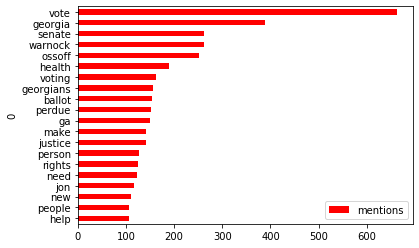

In [33]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(demcast_tweets['cleantext'], 20)
#for word, freq in common_words:
#    print(word, freq)
common_words_df = pd.DataFrame(common_words)
fig, ax = plt.subplots()
common_words_df.plot.barh(x=0, y=1, color='r', ax=ax).invert_yaxis()
ax.legend(["mentions"])

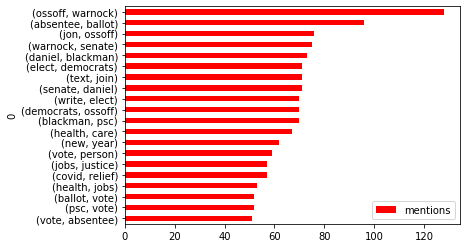

In [34]:
bigrams = [(x, i.split()[j + 1]) for i in demcast_tweets['cleantext']  
       for j, x in enumerate(i.split()) if j < len(i.split()) - 1]
frequency_dist_bigrams = FreqDist(bigrams)
common_bigrams_df = pd.DataFrame(frequency_dist_bigrams.most_common(20))
fig, ax = plt.subplots()
common_bigrams_df.plot.barh(x=0, y=1, color='r', ax=ax).invert_yaxis()
ax.legend(["mentions"]);

In [35]:

# Only alphabet, contains at least 3 letters, and appears > 10 times in the text
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(1, 1),
                              min_df=10)
count_vectorized = vectorizer.fit_transform(demcast_tweets['cleantext'])
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
vectorized = tfidf_transformer.fit_transform(count_vectorized)
vector_matrix = pd.DataFrame(vectorized.toarray(), 
             index=['message '+str(i) 
                    for i in range(1, 1+len(demcast_tweets['cleantext']))],
             columns=vectorizer.get_feature_names())

In [36]:
pairwise_cov_matrix = vector_matrix.cov()

In [37]:
pairwise_cor = np.corrcoef(pairwise_cov_matrix)
words = list(pairwise_cov_matrix.columns) 
pairwise_cor_matrix = pd.DataFrame(pairwise_cor, columns = words, index = words)

In [38]:
def corr_network(matrix, topics, words):
    temp_mat = matrix[matrix.index.isin(topics)]
    temp_df = pd.DataFrame(temp_mat.T.unstack().reset_index(name='correlation').sort_values('correlation', ascending=False))
    temp_df = temp_df.rename(columns={"level_0": 'topic', "level_1": 'word'})
    temp_df = temp_df.sort_values(['topic','correlation'], ascending=False).reset_index(drop=True)
    temp_df = temp_df[temp_df['topic'] != temp_df['word']]
    return temp_df.groupby(['topic'],as_index=False).apply(lambda x: x.nlargest(words, 'correlation'))

pairwise_cor_network = corr_network(pairwise_cor_matrix, common_words_df[0], 10)

In [39]:
pairwise_cor_network[pairwise_cor_network['topic'] == 'warnock']

topic        word  correlation
18 1   warnock      ossoff     0.824685
   2   warnock     raphael     0.618592
   3   warnock        text     0.612451
   4   warnock   democrats     0.608893
   5   warnock    blackman     0.608652
   6   warnock         psc     0.597858
   7   warnock       elect     0.596738
   8   warnock  resolution     0.593864
   9   warnock      daniel     0.586985
   10  warnock        vote     0.578284

/Users/sam/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


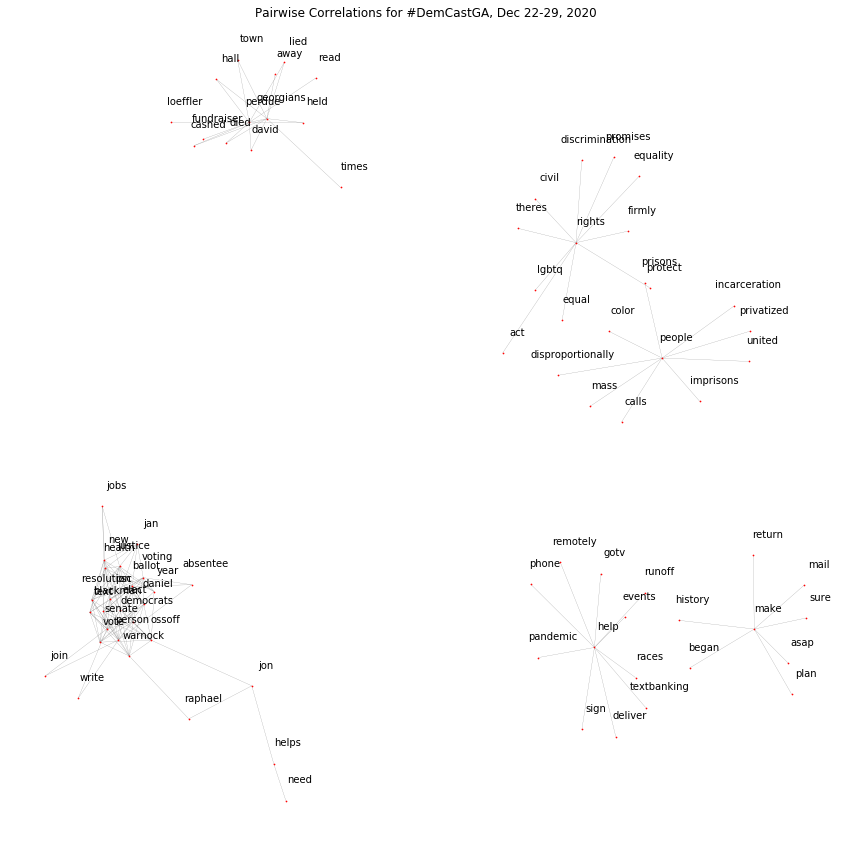

In [42]:
np.random.seed(2020)
pairwise_cor_network_clean = pairwise_cor_network[pairwise_cor_network['correlation'] > 0.4]
G = nx.from_pandas_edgelist(pairwise_cor_network_clean, source='word', target='topic', edge_attr=True)
fig, ax = plt.subplots(figsize=(15, 15))

#pos = nx.spring_layout(G, k=10/G.order())
#pos = nx.spiral_layout(G)
pos = nx.fruchterman_reingold_layout(G, k=20/G.order())
#pos = nx.kamada_kawai_layout(G)
#pos = nx.spectral_layout(G)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=8,
                 width=0.2,
                 node_size = 0.5,
                 edge_color='grey',
                 node_color='red',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.035, value[1]+.045
    ax.text(x, y,
            s=key,
            #bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=10)
    
plt.axis('off')
plt.title("Pairwise Correlations for #DemCastGA, Dec 22-29, 2020")
plt.savefig('demcastga_tweets.pdf', dpi=300, bbox_inches="tight")